In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle

In [12]:
'''
Constants
'''
kp = 1.0                # kp index
gs = 2.0                # shileding constant
RE = 6371000            # equatorial radius of earth [km] 

# plot attributes
pcolor = 'GnBu'

In [13]:
'''
Additional functions
'''
def crt_to_sph(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2) # radial distance
    theta = np.arccos(z/r)          # polar angle
    phi = np.arctan2(y,x)           # azimuthal angle

    return r, theta, phi

def rdist(l, mlt):
    ang = mlt*15*(np.pi/180)
    r = l*RE#*np.sin(ang)**2
    return r
    
def mag(vec):

    magnitude = np.sqrt(np.dot(vec, vec))
    return magnitude


In [14]:
def add_offscale_RE(ax):
    '''
    Based on stack overflow question 16605137
    '''
    offset = 0.15

    # create new axis and set position below plot
    rect = ax.get_position()
    rect = (rect.xmin+rect.width/2, rect.ymin-offset, rect.width/2, rect.height/2)
    scale_ax = ax.figure.add_axes(rect)

     # hide un-needed elements
    for loc in ['right', 'left', 'top']:
        scale_ax.spines[loc].set_visible(False)  
    scale_ax.tick_params(left=False, labelleft=False)
    scale_ax.patch.set_visible(False) 

    scale_ax.spines['bottom'].set_bounds(*ax.get_ylim())
    scale_ax.set_xticks(ax.get_yticks())
    scale_ax.set_xlim(ax.get_rorigin(), ax.get_rmax())
    scale_ax.set_xlabel('$R_E$')


In [15]:
def draw_earth(ax):
    '''
    A handy function for drawing the Earth in a set of Polar Axes
    
    Soruce: IMEF (M. Argall)
    '''
    ax.fill_between(np.linspace(-np.pi / 2, np.pi / 2, 30), 0, np.ones(30), color='k')
    ax.fill_between(np.linspace(np.pi / 2, 3 * np.pi / 2, 30), np.ones(30), color='w')
    
    ax.plot(np.linspace(np.pi / 2, 3 * np.pi / 2, 30), np.ones(30), color='k')

### Volland-Stern potential and convection electric field

Volland-Stern Convection field, where the potential can be written as
$$\phi_{c}=-E_{0} r^{\gamma} \sin \psi \tag{Ferradas 2017; 1.16}$$
Where the magnetic local time ($\psi$) is related to azimuth by $\psi = \phi/24$, and the  uniform convection electric field strength in the equatorial plane $E_0$ is
$$E_{0}=\frac{0.045}{\left(1-0.159 K p+0.0093 K p^{2}\right)^{3}} \frac{k V}{R_{E}^{2}}
\tag{Ferradas 2017; 2.4}$$
By solving the gradient $E_c = -\nabla \phi_c$, we find our equation for the convection potential:
$$E_{r} = E_0 \left (\gamma r^{\gamma-1}\sin (\phi/24) \hat{\mathbf{r}} +  0\hat{\boldsymbol{\theta}} + \frac{r^{\gamma-1}}{24\sin\theta}\cos (\phi/24) \hat{\boldsymbol{\phi}} \right )$$


In [16]:
def convection_field(kp):
    
    # uniform convection electric field strength in equatorial plane [kV]
    E0 = 0.045/((1-(0.159*kp) + (0.0093*kp**2))**3*(RE**2.))
    return E0

def vs_potential(coords, gs, kp, sph = False):
    
    if sph == False:
        # convert cartesian to spherical coordinates
        rgeo, theta, phi = crt_to_sph(coords[0], coords[1], coords[2])

    else:
        # unpack coordinates
        rgeo  = coords[0]
        theta = coords[1]
        phi   = coords[2]

    # uniform convection electric field strength in equatorial plane [kV]
    E0 = convection_field(kp)

    # VS potential
    U = -E0*(rgeo**gs)*math.sin(phi)
    
    return U


In [17]:
def vs_efield(coords, gs, kp, sph = False):
    
    if sph == False:
        # convert cartesian to spherical coordinates
        rgeo, theta, phi = crt_to_sph(coords[0], coords[1], coords[2])

    else:
        # unpack coordinates
        rgeo  = coords[0]
        theta = coords[1]
        phi   = coords[2]

    
    # uniform convection electric field strength in equatorial plane [kV]
    E0 = convection_field(kp)

    # VS efield
    EC0 = E0*gs*(rgeo**(gs-1))*(np.sin(phi))                        # radial componenet
    EC1 = 0.                                                        # polar component
    EC2 = E0*(rgeo**(gs-1))*(1/(np.sin(theta)))*(np.cos(phi))       # azimuthal component

    EC = np.array([EC0, EC1, EC2])
    
    return EC




### Calculating grid of potential and electric field values

In [18]:
lmax = 10 
mltmax = 24

# convert to radial geo and theta

rmax = lmax*RE                  # rdist(lmax, mltmax)
pmax = mltmax*15*(np.pi/180)    # max angle
dr = 300                        # incrementation


# coordinates

rn = np.linspace(0., rmax, dr)
pn = np.linspace(0., pmax, dr)

r, phi = np.meshgrid(rn, pn)

ln = np.linspace(0, lmax, dr)
mn = np.linspace(0.0, mltmax, dr)


l, mlt = np.meshgrid(ln, mn)


# array 
emap_new = np.zeros(r.shape) # E field
umap_new = np.zeros(r.shape) # Potential

# calculate potential and assign values to array
for i in range(0,dr):
    for j in range(0,dr):
        
        r0 = r[i,j]
        p0 = phi[i,j]
        coords = np.array([r0, np.pi/2., p0])

        EC = mag(vs_efield(coords, gs, kp, sph = True))

        emap_new[i,j] = mag(vs_efield(coords, gs, kp, sph = True))
        umap_new[i,j] = vs_potential(coords, gs, kp, sph = True)
        
# remove unwanted datapoints within 1RE
bad = np.where(r < RE)
emap_new[bad] = np.nan

### Plotting the electric field

/tmp/ipykernel_171/2120149067.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=pcolor, shading='nearest')


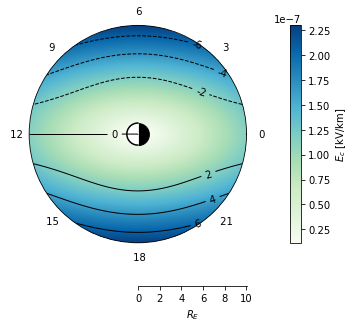

In [38]:
'''
plot of electric and potential
'''
# plot in radial axis scale of RE (L-Shell)
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'))
ax1 = axes[0, 0]

# plot E-field
eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=pcolor, shading='nearest')
fig.colorbar(eplot, ax=ax1, pad=0.13, label="$E_c$ [kV/km]")

# plot potential contours
uplot = ax1.contour(phi, rscale, umap_new, 8, colors='k', linewidths=1) 
ax1.clabel(uplot, uplot.levels, fmt = '%1.0f')

# set clockwise labels
# ax1.set_theta_direction(-1)

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# scale radial axis by RE (L-shell) - only if not plotting with rscale
#scale_rad = ticker.FuncFormatter(lambda r, pos: '{0:.0f}'.format(r/RE))
#ax1.yaxis.set_major_formatter(scale_rad)

# place 0 at top
#ax1.set_theta_zero_location('N')  
#ax1.set_theta_offset(np.pi/2.0) 

# adjust angle of radial axis labels  - only if not plotting with rscale
# ax1.set_rlabel_position(0) 

#fig.suptitle(f"Volland-Stern Electric Field $E_c$ ($K_p =$ {kp})", y = 1.05)
#fig.colorbar(fig1, ax=ax1)


# hide radial labels and add RE-scaled subaxis 
ax1.set_yticklabels([])
add_offscale_RE(ax1)

# draw the earth
draw_earth(ax1)

plt.show()

# save figure
fname = 'plot_VS_efield_full'
#plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)

### Refrences
* Volland, H. 1973. “A semiempirical model of large-scale magnetospheric electric fields.”Journal of Geophysical
Research.https://doi.org/10.1029/JA078i001p00171.
* Stern, D. 1975. The motion of a proton in the equatorial magnetosphere. Journal of Geophysical
Research.https://doi.org/10.1029/JA080i004p00595.
* Ferradas, C. (2017). <i>Understanding Ion Spectral Dynamics Near the Inner Edge Of The Plasma Sheet. https://scholars.unh.edu/dissertation


### TBO

In [1]:
def set_axis_l_mlt(ax):

    # scale radial axis by RE (L-shell)
    scale_rad = ticker.FuncFormatter(lambda r, pos: '{0:.0f}'.format(r/RE))
    ax1.yaxis.set_major_formatter(scale_rad)

    # scale angular by MLT
    scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0:5.0f}'.format(math.radians(phi)/15))
    ax1.xaxis.set_major_formatter(scale_ang)

In [9]:
te = 10
ne = 2e18
qe = 1.602e-19
e0 = 8.84e-12
b=0.004
me = 9.109e-31

deb = np.sqrt((e0*te)/(ne*qe))

rl = 3.37e-6*np.sqrt(te)/b

wp = 56.4*np.sqrt(ne)

wc = qe*b/me
wc

703480074.6514437

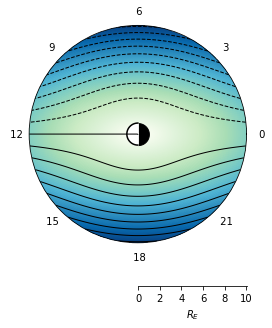

In [36]:
'''
plot of electric and potential
'''
# plot in radial axis scale of RE (L-Shell)
rscale = r/RE

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, subplot_kw=dict(projection='polar'))
ax1 = axes[0, 0]
ax1.grid(False)

# plot E-field
eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=pcolor, shading='nearest')

# plot potential contours
uplot = ax1.contour(phi, rscale, umap_new, 23, colors='k', linewidths=1) 
#ax1.clabel(uplot, uplot.levels, fmt = '%1.0f')

# set clockwise labels
# ax1.set_theta_direction(-1)

# scale angular by MLT
scale_ang = ticker.FuncFormatter(lambda phi, pos: '{0: .0f}'.format(math.degrees(phi/15)))
ax1.xaxis.set_major_formatter(scale_ang)

# hide radial labels and add RE-scaled subaxis 
ax1.set_yticklabels([])
add_offscale_RE(ax1)

# draw the earth
draw_earth(ax1)

#plt.show()

# save figure
fname = 'plot_VS_contour'
plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)